# Название диплома: Нейросетевое предсказание поведения агента в реальном времени

Цель: Целью данного исследования является создание нейронной сети, которая будет предсказывать поведение агента в реальном ремени.

Задачи:

1) Создать прототип нейронной сети, протестировать его и обучить на тестовых данных;

2) Подготовить базу данных на основе разметки и существующих сведений о движениях на видеофайлах;

3) Подготовить обучающую (Dataset) и контрольную выборки;

4) Обучить и протестировать созданную нейронную сеть.

Данные: 26-мерный временной ряд.

Архитектуры и структуры нейронных сетей:

В моей работе определена простая нейронная сеть с тремя полносвязанными слоями и функциями активации ReLU между ними. Это типичная архитектура нейронной сети для задач регрессии, которую я как раз и хочу решить. В данной работе используется метод обратного распространения ошибки для обучния нейросети, обучение происходит с учителем, Batch size = 32, используется оптимизатор Adam (Adaptive Moment Estimation), который эффективно обновляет веса модели на основе адаптивной оценки момента первого и второго порядка градиентов.

Функция потерь и метрика:

В данной работе я использую loss l2, так как l1 для моей работы показывает результаты хуже, нежели чем l2. Ошибки я считаю по стандартной формуле: $\sqrt{(x_{true} - x_{pred})^ 2 + (y_{true} - y_{pred})^ 2}$. 

Средства необходимые для достижения цели:

Для достижения цели мне понадобится python, opencv, pytorch, numpy. А также мне понадобятся роботы модели saharmono и saharstereo, 

### Импорт библиотек

In [3]:
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Обучение модели ___PyTorch___

In [4]:
# Создание модели нейронной сети
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(2, 128) 
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

model = NeuralNet()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Генерируйте данные, соответствующие движению круга по окружности
def generate_circle_data():
    center_x, center_y = 640 // 2, 480 // 2
    radius = 200
    angle = 0
    angular_speed = 0.025
    x_coords, y_coords = [], []

    for i in range(3000):
        x = int(center_x + radius * np.cos(angle))
        y = int(center_y + radius * np.sin(angle))
        angle += angular_speed
        x_coords.append(x)
        y_coords.append(y)
    
    return x_coords, y_coords

X, Y = generate_circle_data()

# Обучение модели на сгенерированных данных
X_train = np.column_stack((X[:-1], Y[:-1]))  # Прошлые координаты
y_train = np.column_stack((X[1:], Y[1:]))    # Будущие координаты

X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Создайте списки для сохранения значений потерь и ошибки
loss_history = []

# Обучение модели
num_epochs = 25
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_history.append(running_loss / len(dataloader))

In [5]:
print(model)

NeuralNet(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)


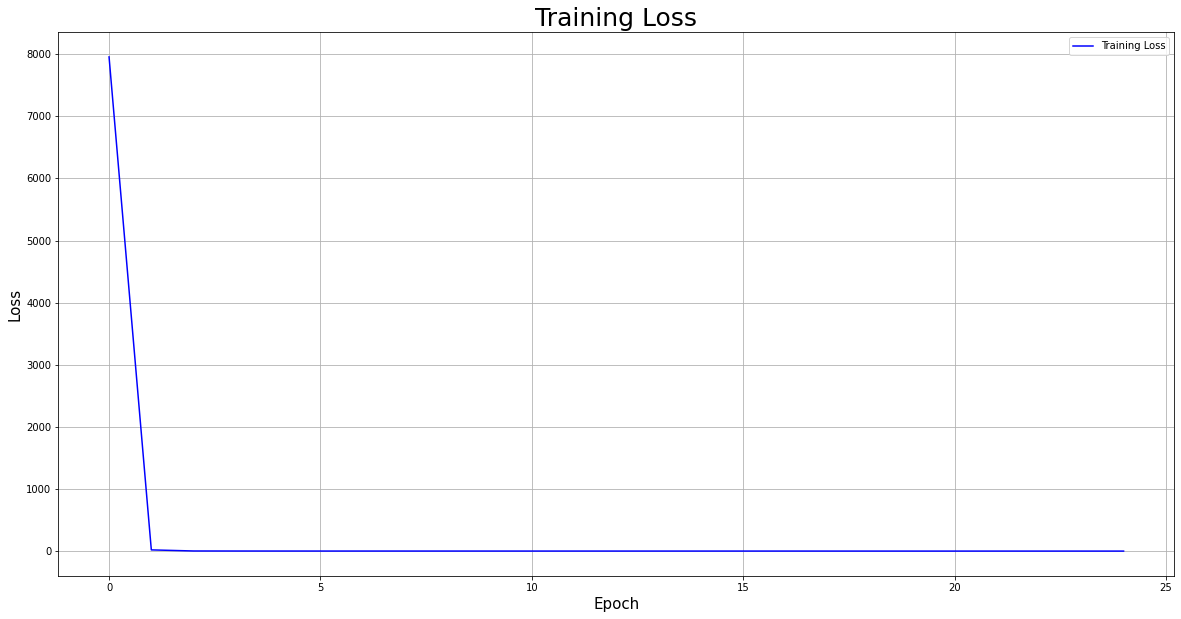

In [3]:
# Создайте график потерь
plt.figure(figsize=(20, 10))
plt.plot(loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.title('Training Loss', fontsize=25)
plt.legend()
plt.grid(True)
plt.show()

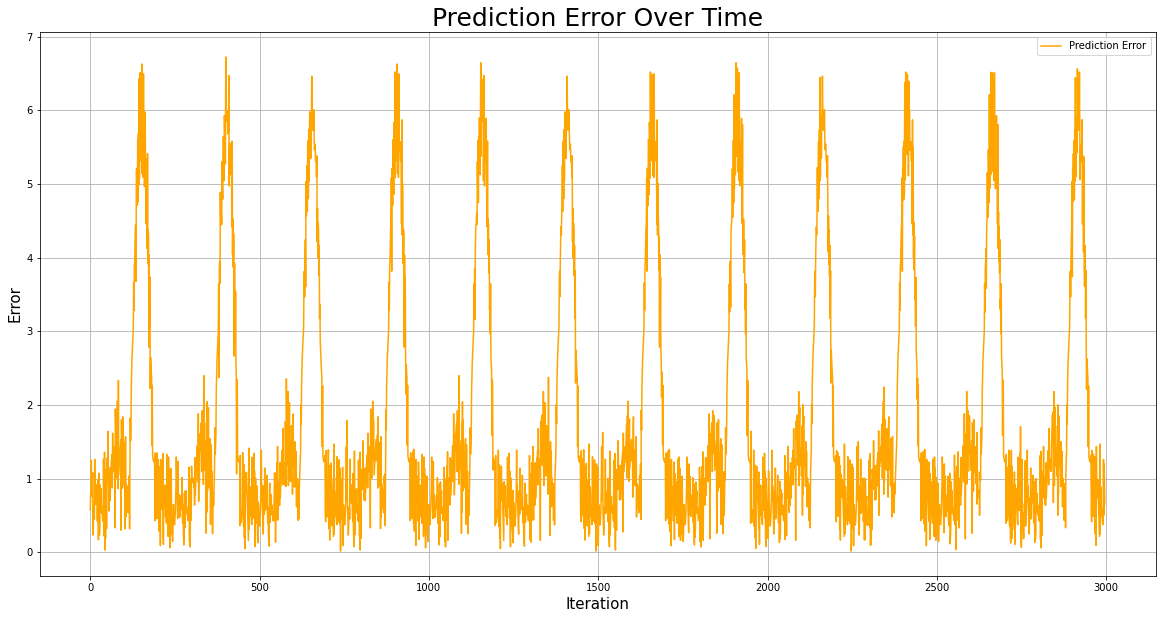

In [7]:
# Создайте пустой список для ошибок
errors = []

model.eval()  # Переключение в режим оценки (без обучения)
with torch.no_grad():
    for i in range(1, len(y_train) - 1):
        x_true, y_true = y_train[i]
        x_pred, y_pred = model(X_train_tensor[i:i+1]).squeeze().numpy()
        error = np.sqrt((x_true - x_pred) ** 2 + (y_true - y_pred) ** 2)
        errors.append(error)

# Создайте график ошибок
plt.figure(figsize=(20, 10))
plt.plot(errors, label='Prediction Error', color='orange')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Error', fontsize=15)
plt.title('Prediction Error Over Time', fontsize=25)
plt.legend()
plt.grid(True)
plt.show()

### Визуализация ___PyTorch___

In [5]:
# Создайте пустое изображение с белым фоном
width, height = 640, 640
image = np.zeros((height, width, 3), dtype=np.uint8)
image.fill(255)

# Начальные параметры круга
center_x, center_y = width // 2, height // 2  # Центр окружности
radius = 200  # Увеличьте радиус окружности
angle = 0  # Начальный угол

# Задайте скорость движения круга по окружности
angular_speed = 0.025  # Изменяйте этот параметр для управления скоростью

# Параметры трейсера движения
trail_length = 100  # Длина трейсера (количество точек)
trail = []  # Массив для хранения трейсера

# Переменная для отслеживания количества итераций
iteration_count = 0

# Массив для хранения оранжевых кругов и их прозрачности
orange_circles = []

while True:
    # Вычислите новое положение круга
    x = int(center_x + radius * np.cos(angle))
    y = int(center_y + radius * np.sin(angle))

    # Добавьте текущее положение круга в трейсер
    trail.insert(0, (x, y))

    # Ограничьте длину трейсера
    if len(trail) > trail_length:
        trail.pop()

    # Очистите изображение
    image.fill(255)

    # Нарисуйте координатную сетку
    grid_color = (200, 200, 200)
    grid_spacing = 50
    for i in range(0, width, grid_spacing):
        cv2.line(image, (i, 0), (i, height), grid_color, 1)
        cv2.putText(image, str(i), (i, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, grid_color, 1)
    for j in range(0, height, grid_spacing):
        cv2.line(image, (0, j), (width, j), grid_color, 1)
        cv2.putText(image, str(j), (10, j), cv2.FONT_HERSHEY_SIMPLEX, 0.5, grid_color, 1)
    
    # Нарисуйте траекторию движения зеленого круга
    cv2.circle(image, (center_x, center_y), radius, (0, 100, 0), 2)
    
    # Нарисуйте заголовок
    cv2.putText(
        image, 'Moving Circle with Trail and Predictions', (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2
    )

    # Нарисуйте легенду
    cv2.putText(image, 'Green - Trajectory', (10, height - 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (168, 228, 160), 2)
    cv2.putText(image, 'Orange - Prediction', (10, height - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 127, 255), 2)

    # Нарисуйте трейсер движения
    for i, point in enumerate(trail):
        alpha = i / float(trail_length)  # Прозрачность уменьшается по мере удаления от шара
        thickness = int(5 * (1 - alpha))  # Толщина линии увеличивается к шару и уменьшается далее
        cv2.circle(image, point, thickness, (189, 236, 182), -1)
    
    # Если началась предсказательная фаза (после второго круга движения)
    if iteration_count >= 7:
        # Передайте текущее положение круга в модель PyTorch для предсказания будущих позиций
        future_positions = []
        temp_angle = angle
        for i in range(7, 56, 7):            
            x_temp = int(center_x + radius * np.cos(temp_angle))
            y_temp = int(center_y + radius * np.sin(temp_angle))
            #temp_angle += angular_speed
            temp_angle = angle + i*angular_speed
            #print(f"TEMP: ({x_temp}, {y_temp}), CURRENT: ({x}, {y})")            
            current_position = torch.Tensor([[x_temp, y_temp]])
            predicted_position = model(current_position).detach().numpy()[0]
            future_x, future_y = predicted_position
            future_positions.append((int(future_x), int(future_y)))
            #print(f"TEMP: ({x_temp}, {y_temp}), FUTURE: ({future_x}, {future_y})")
        #print()
        
        # Обновление состояния оранжевых кругов (затухание и добавление новых)
        new_orange_circles = []
        for circle in orange_circles:
            circle['alpha'] -= 0.02  # Уменьшите прозрачность оранжевого круга
            if circle['alpha'] > 0:
                new_orange_circles.append(circle)
        orange_circles = new_orange_circles

        for i, position in enumerate(future_positions):
            if i >= len(orange_circles):
                # Создайте новый оранжевый круг
                orange_circle = {
                    'position': position,
                    'alpha': (i * 2) / (len(future_positions) + 1)  # Прозрачность увеличивается с удалением от зеленого
                }
                orange_circles.append(orange_circle)

        # Отрисовка оранжевых кругов с окантовкой для предсказанных позиций
        for circle in orange_circles:
            alpha = circle['alpha']
            thickness = int(5 * alpha)  # Уменьшайте толщину оранжевого круга по мере удаления от зеленого
            cv2.circle(image, circle['position'], 15, (0, 127, 255), thickness) # оранжевый круг с окантовкой
            
    # Нарисуйте круг на текущем положении
    cv2.circle(image, (x, y), 15, (168, 228, 160), 2) # Зеленый пастельный круг с окантовкой
    
    # Показать изображение
    cv2.imshow('Moving Circle with Trail and Predictions', image)
    
    # Обновление угла для следующего шага движения
    angle += angular_speed

    # Увеличение счетчика итераций
    iteration_count += 1

    # Для выхода из цикла нажмите 'q'
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Закрыть окно при завершении
cv2.destroyAllWindows()
cv2.waitKey(10)

-1